In [34]:
import math

expression_file_content = [line.split("\t") for line in open("../gold_standard_sentences/expression.tsv")]
expression_headers = expression_file_content[0]
expression_data = expression_file_content[1:]
expression_data = [row for row in expression_data if row[2]]

In [28]:
kinaseact_file_content = [line.split("\t") for line in open("../gold_standard_sentences/kinase_activity.tsv")]
kinaseact_headers = kinaseact_file_content[0]
kinaseact_data = kinaseact_file_content[1:]
kinaseact_data = [row for row in kinaseact_data if row[2]]

In [53]:
cleaned_expression_data = []
for row in expression_data:
    cleaned_expression_data.append([*row[0:3], "c_elegans" if row[5] != "" else "mixed" if row[6] != "" else "other", "positive" if row[22] != "" else "negative" if row[23] != "" else "both" if row[24] != "" else "neutral", 0 if row[14] != "" else 1 if row[15] != "" else 2 if row[16] != "" else 3 if row[17] != "" else 4 if row[18] != "" else 5 if row[19] != "" else 6 if row[20] != "" else 7])

cleaned_kinaseact_data = []
for row in kinaseact_data:
    cleaned_kinaseact_data.append([*row[0:3], "c_elegans" if row[5] != "" else "mixed" if row[6] != "" else "other" if row[7] != "" else "no_species", "positive" if row[22] != "" else "negative" if row[23] != "" else "both" if row[24] != "" else "neutral", 0 if row[14] != "" else 1 if row[15] != "" else 2 if row[16] != "" else 3 if row[17] != "" else 4 if row[18] != "" else 5 if row[19] != "" else 6 if row[20] != "" else 7])

cleaned_expression_data_orig = cleaned_expression_data[:]
cleaned_kinaseact_data_orig = cleaned_kinaseact_data[:]

cleaned_headers = ["pmid", "wb_paper_id", "sentence", "species", "result_type", "class"]


In [5]:
from sentence_classification.preprocess import clean_sentences_with_papid, read_sentences_from_file_with_papid
from random import shuffle

neg_sent_otherexpr = read_sentences_from_file_with_papid("../extracted_sentences/neg_sentences_otherexpr.txt")
neg_sent_otherexpr_cleaned = clean_sentences_with_papid(neg_sent_otherexpr)
shuffle(neg_sent_otherexpr_cleaned)



cleaned_expression_data.extend(["", "WBPaper" + row[0], row[1], "", "", 8] for row in neg_sent_otherexpr_cleaned[0:500])

neg_sent_kineaseact = read_sentences_from_file_with_papid("../extracted_sentences/neg_sentences_kinase_activity.txt")
neg_sent_kineaseact_cleaned = clean_sentences_with_papid(neg_sent_kineaseact)
shuffle(neg_sent_kineaseact_cleaned)

cleaned_kinaseact_data.extend(["", "WBPaper" + row[0], row[1], "", "", 8] for row in neg_sent_kineaseact_cleaned[0:500])

In [6]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [7]:
corpus_expr = embedder.encode([row[2] for row in cleaned_expression_data], convert_to_tensor=True)
corpus_kinaseact = embedder.encode([row[2] for row in cleaned_kinaseact_data], convert_to_tensor=True)

In [8]:
import umap

umap_reducer = umap.UMAP(metric='cosine')
corpus_expr_2d = umap_reducer.fit_transform(corpus_expr)
corpus_kinaseact_2d = umap_reducer.fit_transform(corpus_kinaseact)

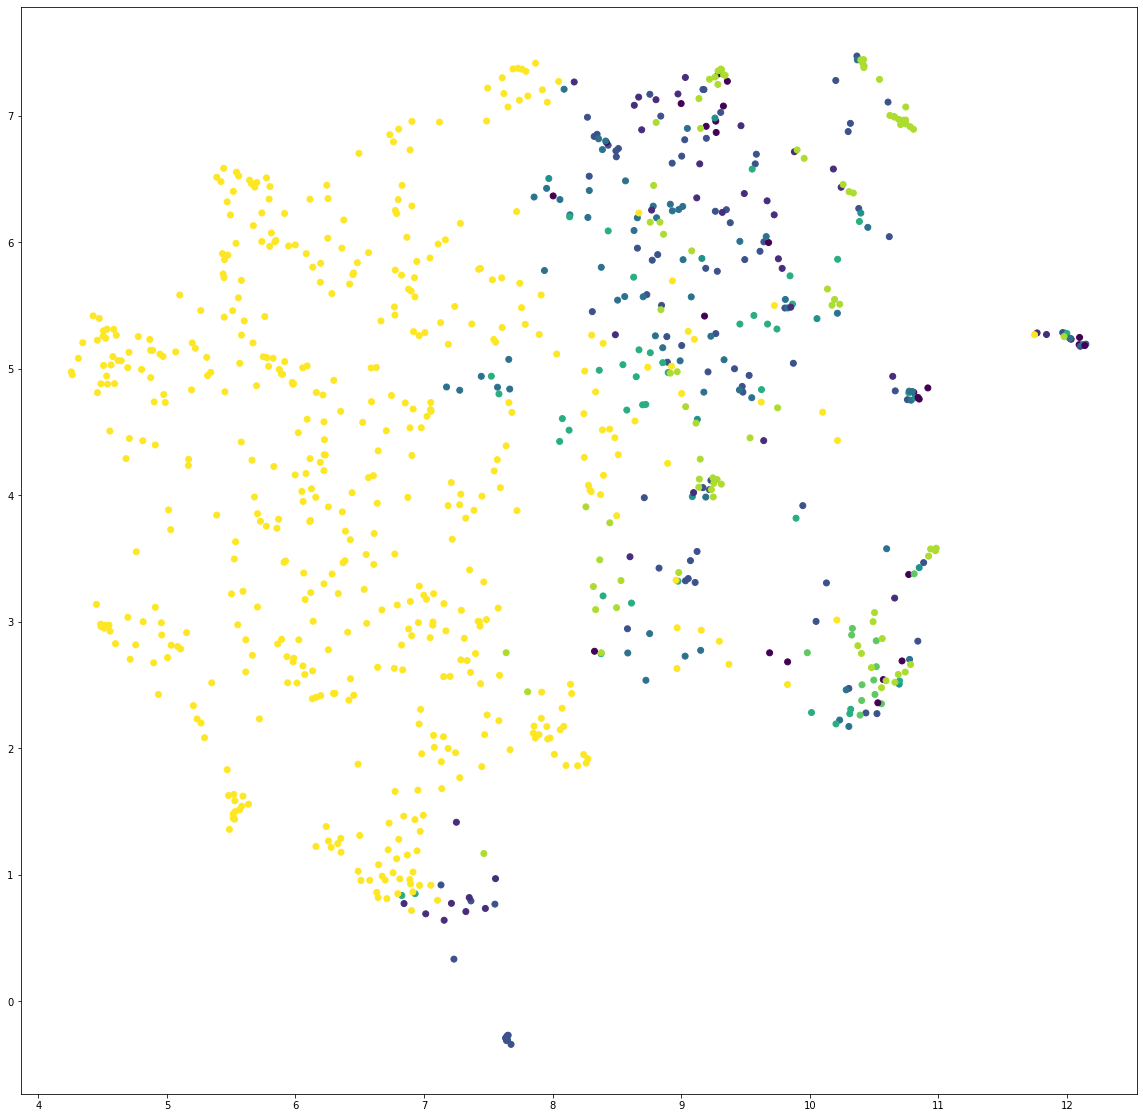

In [9]:
from matplotlib import pyplot as plt

colors_expr = [row[5] for row in cleaned_expression_data]
fig_scatter = plt.figure(figsize=(20, 20))
plt.scatter(x=list(corpus_expr_2d[:,0]), y=list(corpus_expr_2d[:,1]), c=colors_expr)

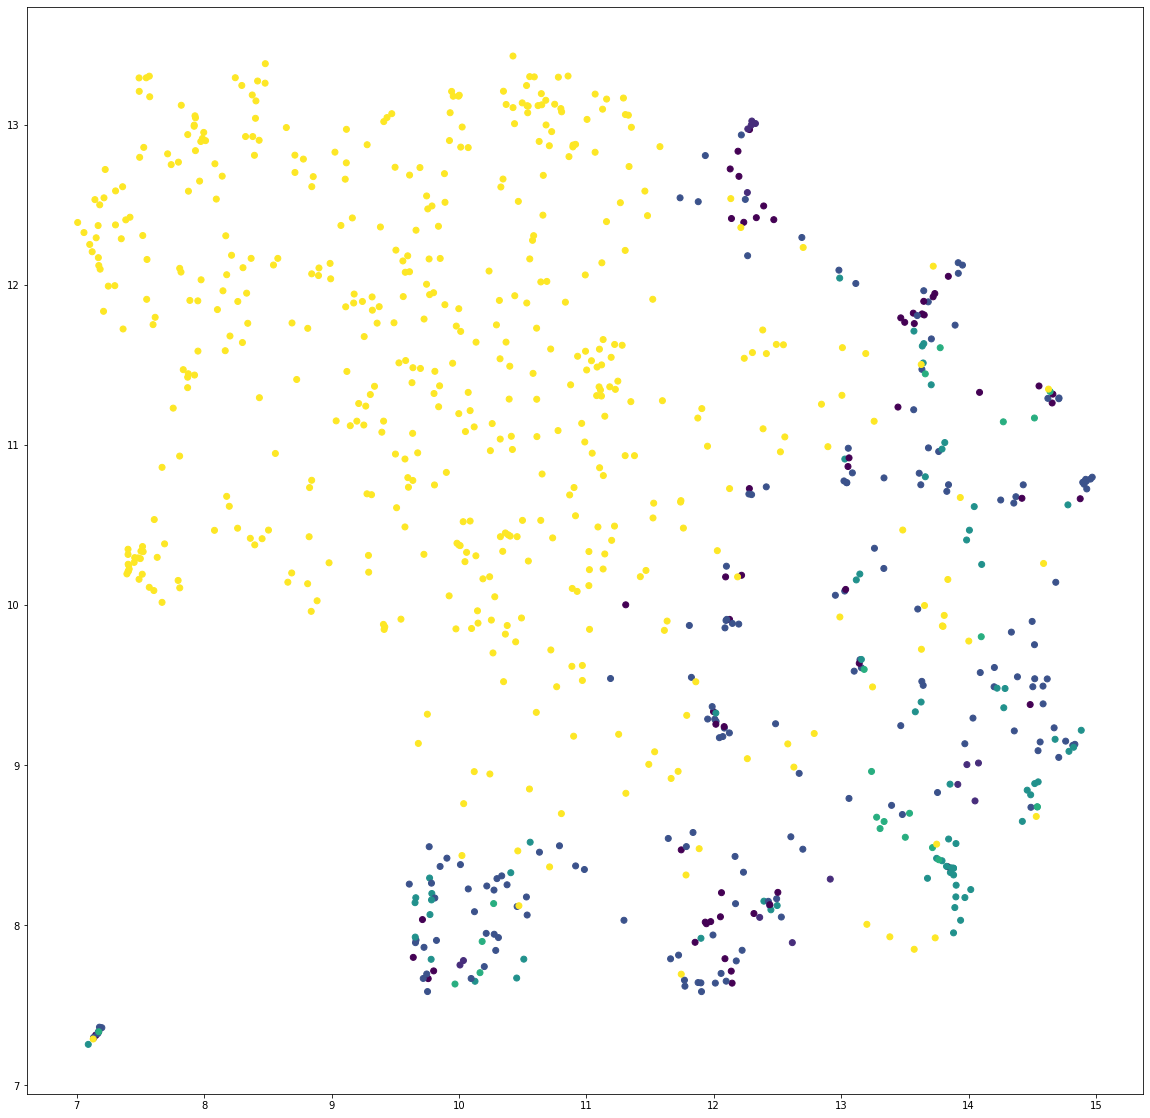

In [10]:
colors_kinaseact = [row[5] for row in cleaned_kinaseact_data]
fig_scatter_kinase = plt.figure(figsize=(20, 20))
plt.scatter(x=list(corpus_kinaseact_2d[:,0]), y=list(corpus_kinaseact_2d[:,1]), c=colors_kinaseact)

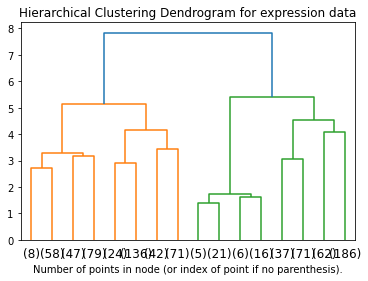

In [11]:
from sentence_classification.clustering import plot_dendrogram
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering

X_expr = corpus_expr

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0.2, n_clusters=None)

model_expr = model.fit(X_expr)
plt.title("Hierarchical Clustering Dendrogram for expression data")
# plot the top three levels of the dendrogram
plot_dendrogram(model_expr, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

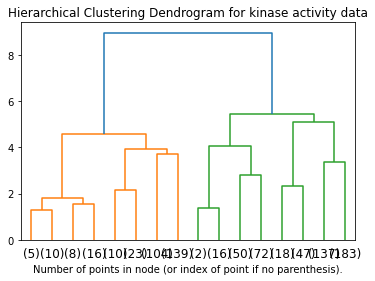

In [12]:
X_kinaseact = corpus_kinaseact

model_kinaseact = model.fit(X_kinaseact)
plt.title("Hierarchical Clustering Dendrogram for kinase activity data")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# precision and recall using clustering with n_clusters = 2

In [13]:
model_fixed = AgglomerativeClustering(n_clusters=2)
model_fixed_expr = model_fixed.fit(X_expr)
model_fixed_kinaseact = model_fixed.fit(X_kinaseact)
tp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] == 2])
tn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] != 2])
fp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] != 2])
fn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] == 2])
precision_curatable_only_expr = tp_expr / (tp_expr + fp_expr)
recall_curatable_only_expr = tp_expr / (tp_expr + fn_expr)

tp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] == 2])
tn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] != 2])
fp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] != 2])
fn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] == 2])
precision_curatable_only_kinaseact = tp_kinaseact / (tp_kinaseact + fp_kinaseact)
recall_curatable_only_kinaseact = tp_kinaseact / (tp_kinaseact + fn_kinaseact)

tp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] != 8])
tn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] == 8])
fp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] == 8])
fn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] != 8])
precision_any_class_expr = tp_expr / (tp_expr + fp_expr)
recall_any_class_expr = tp_expr / (tp_expr + fn_expr)

tp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] != 8])
tn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] == 8])
fp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] == 8])
fn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] != 8])
precision_any_class_kinaseact = tp_kinaseact / (tp_kinaseact + fp_kinaseact)
recall_any_class_kinaseact = tp_kinaseact / (tp_kinaseact + fn_kinaseact)

tp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] < 7])
tn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] > 6])
fp_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 1 and cleaned_expression_data[index][5] > 6])
fn_expr = len([1 for index, label in enumerate(model_fixed_expr.labels_) if label == 0 and cleaned_expression_data[index][5] < 7])
precision_no_language_expr = tp_expr / (tp_expr + fp_expr)
recall_no_language_expr = tp_expr / (tp_expr + fn_expr)

tp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] < 7])
tn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] > 6])
fp_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 1 and cleaned_kinaseact_data[index][5] > 6])
fn_kinaseact = len([1 for index, label in enumerate(model_fixed_kinaseact.labels_) if label == 0 and cleaned_kinaseact_data[index][5] < 7])
precision_no_language_kinaseact = tp_kinaseact / (tp_kinaseact + fp_kinaseact)
recall_no_language_kinaseact = tp_kinaseact / (tp_kinaseact + fn_kinaseact)

print("precision curatable only expression: " + str(precision_curatable_only_expr))
print("recall curatable only expression: " + str(recall_curatable_only_expr))
print("precision curatable only kinase activity: " + str(precision_curatable_only_kinaseact))
print("recall curatable only kinase activity: " + str(recall_curatable_only_kinaseact))

print("precision any class expression: " + str(precision_any_class_expr))
print("recall any class expression: " + str(recall_any_class_expr))
print("precision any class kinase activity: " + str(precision_any_class_kinaseact))
print("recall any class kinase activity: " + str(recall_any_class_kinaseact))

print("precision no language expression: " + str(precision_no_language_expr))
print("recall no language expression: " + str(recall_no_language_expr))
print("precision no language kinase activity: " + str(precision_no_language_kinaseact))
print("recall no language kinase activity: " + str(recall_no_language_kinaseact))

precision curatable only expression: 0.2571428571428571
recall curatable only expression: 0.9
precision curatable only kinase activity: 0.5047619047619047
recall curatable only kinase activity: 0.9190751445086706
precision any class expression: 0.9904761904761905
recall any class expression: 0.8455284552845529
precision any class kinase activity: 0.9873015873015873
recall any class kinase activity: 0.9147058823529411
precision no language expression: 0.834920634920635
recall no language expression: 0.9326241134751773
precision no language kinase activity: 0.9873015873015873
recall no language kinase activity: 0.9147058823529411


# classifiers

In [14]:
from sklearn.neural_network import MLPClassifier
import math

converted_corpus_expr = corpus_expr.numpy()
converted_corpus_kinaseact = corpus_kinaseact.numpy()
indices_expr = [i for i in range(len(corpus_expr))]
shuffle(indices_expr)
training_size_expr = math.ceil(len(corpus_expr) * 0.8)
training_indices_expr = indices_expr[0:training_size_expr]
test_indices_expr = indices_expr[training_size_expr:]
training_set_data_expr = [converted_corpus_expr[index] for index in training_indices_expr]
test_set_classes_expr = [cleaned_expression_data[index][5] for index in test_indices_expr]
indices_kinaseact = [i for i in range(len(corpus_kinaseact))]
shuffle(indices_kinaseact)
training_size_kinaseact = math.ceil(len(corpus_kinaseact) * 0.8)
training_indices_kinaseact = indices_kinaseact[0:training_size_kinaseact]
test_indices_kinaseact = indices_kinaseact[training_size_kinaseact:]
training_set_data_kinaseact = [converted_corpus_kinaseact[index] for index in training_indices_kinaseact]
test_set_classes_kinaseact = [cleaned_kinaseact_data[index][5] for index in test_indices_kinaseact]
base_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

# prediction
## multiclass

In [15]:
from sklearn.metrics import precision_recall_fscore_support as score
training_set_classes_expr = [cleaned_expression_data[index][5] for index in training_indices_expr]
test_set_data_expr = [converted_corpus_expr[index] for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.         0.         0.33333333 0.07692308 0.         0.
 0.         1.         0.97777778]
recall: [0.         0.         1.         0.06666667 0.         0.
 0.         0.05263158 0.89795918]
fscore: [0.         0.         0.5        0.07142857 0.         0.
 0.         0.1        0.93617021]
support: [ 3  4 23 15  1  6  4 19 98]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
training_set_classes_kinaseact = [cleaned_kinaseact_data[index][5] for index in training_indices_kinaseact]
test_set_data_kinaseact = [converted_corpus_kinaseact[index] for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.         0.         0.66666667 0.21428571 0.         0.98989899]
recall: [0.         0.         0.51428571 0.69230769 0.         0.97029703]
fscore: [0.         0.         0.58064516 0.32727273 0.         0.98      ]
support: [ 14   1  35  13   4 101]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## binary
### all classes of gold standard sentences considered positive

In [17]:
training_set_classes_expr = [1 if cleaned_expression_data[index][5] != 8 else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][5] != 8 else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.97894737 0.93589744]
recall: [0.94897959 0.97333333]
fscore: [0.96373057 0.95424837]
support: [98 75]


In [18]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] != 8 else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] != 8 else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [1.         0.98529412]
recall: [0.99009901 1.        ]
fscore: [0.99502488 0.99259259]
support: [101  67]


### all classes but positive for language - negative for curation and negative sentences

In [19]:
training_set_classes_expr = [1 if cleaned_expression_data[index][5] < 7 else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][5] < 7 else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.92173913 0.81034483]
recall: [0.90598291 0.83928571]
fscore: [0.9137931 0.8245614]
support: [117  56]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [20]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] < 7 else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] < 7 else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [1.         0.98529412]
recall: [0.99009901 1.        ]
fscore: [0.99502488 0.99259259]
support: [101  67]


### only directly reports experimental results as positive

In [21]:
training_set_classes_expr = [1 if cleaned_expression_data[index][5] == 2 else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][5] == 2 else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)

test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.93506494 0.68421053]
recall: [0.96       0.56521739]
fscore: [0.94736842 0.61904762]
support: [150  23]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [22]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] == 2 else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][5] == 2 else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)

test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.92086331 0.82758621]
recall: [0.96240602 0.68571429]
fscore: [0.94117647 0.75      ]
support: [133  35]


# Feature analysis for positive sentences

## expression

(0.0, 100.0)

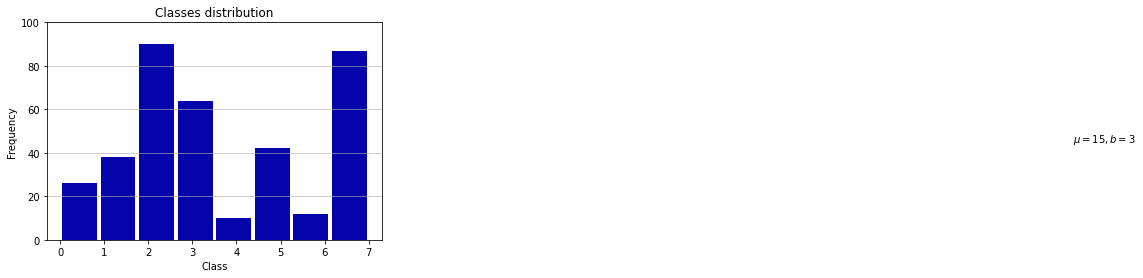

In [55]:
import matplotlib.pyplot as plt
import numpy as np

n, bins, patches = plt.hist(x=[r[5] for r in cleaned_expression_data_orig], bins=8, color='#0504aa',
                            alpha=1, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Classes distribution')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [59]:
[expression_data[i][8] for i, r in enumerate(cleaned_expression_data_orig) if r[5] == 7]

['Results',
 'Description',
 'Abstract',
 'Discussion',
 'Results',
 'Results',
 'Figure legend',
 'Figure legend',
 'Results',
 'Results',
 'Results',
 'Results',
 'Introduction',
 'Materials and methods',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Supplemental material and methods',
 'Figure 2',
 'Figure 1',
 'Method details',
 'Method details',
 'Discussion',
 'Results',
 'Figure 1',
 'Results',
 'Results',
 'Results',
 'Discussion',
 'Results',
 'Figure legend',
 'Figure legend',
 'Figure 4',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Figure 4',
 'Figure 4',
 'Figure 7',
 'Abstract',
 'Results',
 'Results',
 'Figure 3',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Results',
 'Discussion',
 'Results',
 'Results',
 'Figure 6',
 'Results',
 'Abstract',
 'Supplemental Figure S1',
 'Material

# kinase act

(0.0, 180.0)

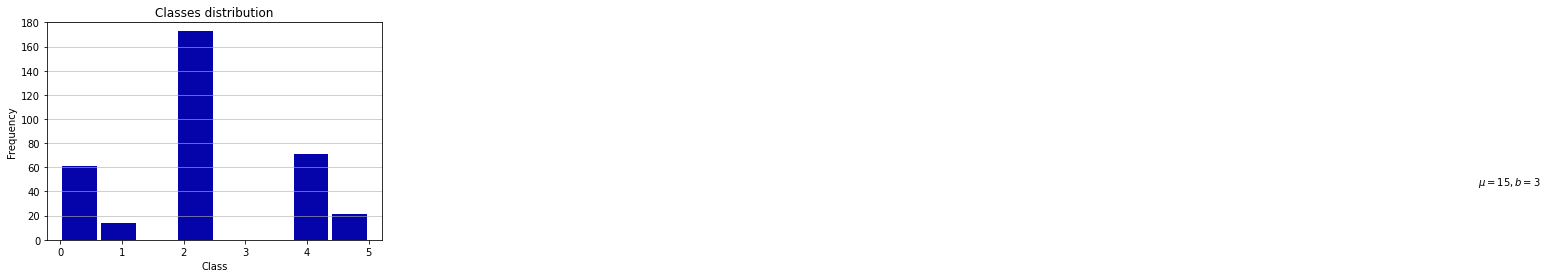

In [56]:
n, bins, patches = plt.hist(x=[r[5] for r in cleaned_kinaseact_data_orig], bins=8, color='#0504aa',
                            alpha=1, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Classes distribution')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)